## Coding Attention Mechanisms

The chapter builds up to multi-head attention by implementing these four variants :

1) **Simplified self-attention (no trainable weights)**   
2) **Self-attention with trainable weights** (learned \(W_q, W_k, W_v\))   
3) **Causal (masked) attention** (self-attention + a mask to hide future tokens)   
4) **Multi-head attention** (multiple attention “heads” run in parallel and combined) 

[1] [Build a Large Language Model (From Scratch) (chapter-3) by Sebastian Raschka](https://livebook.manning.com/book/raschka/chapter-3) and combined)

An **encoder–decoder RNN** is a two-part neural network commonly used (pre-transformers) for tasks like machine translation:

- **Encoder:** reads the input sequence token-by-token and updates a **hidden state** at each step, with the goal that the *final* hidden state becomes a compressed representation of the whole input sentence .
- **Decoder:** takes that final hidden state and then generates the output sequence **one token at a time**, updating its own hidden state as it goes . The book suggests thinking of the encoder’s final hidden state as an “embedding vector” (a single vector summary of the input) .

### The shortcoming that motivated attention
The key limitation is that during decoding, the model **can’t directly access the encoder’s earlier hidden states**. Instead, it must rely on the **current hidden state** (effectively that single compressed summary) to carry *all* relevant information . This “bottleneck” can cause **loss of context**, especially for long or complex sentences with long-range dependencies .

This motivated attention mechanisms (e.g., Bahdanau attention), which modify the setup so the decoder can **selectively access different parts of the input sequence at each decoding step**, rather than depending on only one fixed summary vector .

[1] [Build a Large Language Model (From Scratch) (chapter-3) by Sebastian Raschka](https://livebook.manning.com/book/raschka/chapter-3)

**Self-attention** is a mechanism where **each position (token) in an input sequence “attends to” all other positions in the same sequence** to compute a better representation of the sequence .

Mechanically, self-attention computes a **context vector for each input token** by:
- computing **attention weights** that measure how relevant every other token is to the current token, and then
- using those weights to form a **weighted sum of the input vectors**, producing an “enriched” representation (context vector) for that token .

It’s called **“self”** attention because the relationships are computed **within a single sequence** (the input attends to itself), unlike older attention setups that relate two different sequences (e.g., encoder vs decoder) .

[1] [Build a Large Language Model (From Scratch) (chapter-3) by Sebastian Raschka](https://livebook.manning.com/book/raschka/chapter-3)

In self-attention, the “self” refers to the mechanism’s ability to compute attention weights by relating different positions within a single input sequence. It assesses and learns the relationships and dependencies between various parts of the input itself, such as words in a sentence or pixels in an image.

Input vector of T elements represented x(1) to x(T). This typically represents text that has already been transformed into token embeddings.

Example given is "Your journey begins with a single step" where each element in the sequence corresponds to a d-diminsional embedding vector.

In self-attention, our goal is to calculate context vectors z(i) for each element x(i) in the input sequence. A context vector can be interpreted as an enriched embedding vector





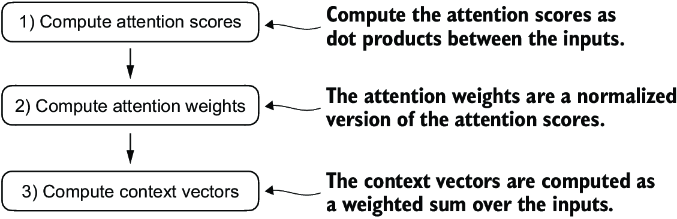

In [3]:
# The source and the 3 dim embeddings

import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [4]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

Attention scores are the **intermediate similarity/alignment values** computed between a **query token** and other tokens in the sequence.

Concretely in the chapter’s simplified self-attention, each attention score \(w\) is computed as a **dot product** between the query vector (e.g., \(x^{(2)}\)) and another input token vector \(x^{(i)}\) . The dot product acts as a **measure of similarity**: a **higher dot product means the vectors are more aligned**, so the model should “attend to” that other token more .

These scores are then **normalized (typically with softmax)** to become **attention weights** that sum to 1 and can be interpreted as relative importance .

[1] [Build a Large Language Model (From Scratch) (chapter-3) by Sebastian Raschka](https://livebook.manning.com/book/raschka/chapter-3)

In [5]:
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [9]:
# A dot product is essentially a concise way of multiplying two vectors element-wise and then summing the products.
# dot product is a measure of similarity because it quantifies how closely two vectors are aligned: a higher dot product 
# indicates a greater degree of alignment or similarity between the vectors

res = 0.
for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]
print(res)
print(torch.dot(inputs[0], query))

tensor(0.9544)
tensor(0.9544)


In [10]:
# The attention weights are the normalized attendtion scores
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


In [11]:
# In practice, it’s more common and advisable to use the softmax function for normalization. This approach is better at managing extreme values and offers 
# more favorable gradient properties during training
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [12]:
# Note that this naive softmax implementation (softmax_naive) may encounter numerical instability problems, 
# such as overflow and underflow, when dealing with large or small input values. Therefore, in practice, 
# it’s advisable to use the PyTorch implementation of softmax, which has been extensively optimized for performance
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


Now that we have computed the normalized attention weights, we are ready for the final step, as shown in figure 3.10: calculating the context vector z(2) by multiplying the embedded input tokens, x(i), with the corresponding attention weights and then summing the resulting vectors. Thus, context vector z(2) is the weighted sum of all input vectors, obtained by multiplying each input vector by its corresponding attention weight

In [13]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


In [18]:
# To compute all context vectors, e.g. the dot products of all pairs of inputs
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [20]:
# We can accomplish the same with matrix multiplication. Note inputs.T is the transpose of the inputs matrix.
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


For matrices \(A \in \mathbb{R}^{m \times n}\) and \(B \in \mathbb{R}^{n \times p}\), their matrix product \(C = AB\) is the \(m \times p\) matrix whose entries are

\[
C_{ij} = \sum_{k=1}^{n} A_{ik}\,B_{kj}.
\]

This is the operation PyTorch performs when you use `tensor2d.matmul(...)` or the `@` operator for matrix multiplication .

[1] [Build a Large Language Model (From Scratch) (appendix-a) by Sebastian Raschka](https://livebook.manning.com/book/raschka/appendix-a)

In the context of using PyTorch, the dim parameter in functions like torch.softmax specifies the dimension of the input tensor along which the function will be computed. By setting dim=-1, we are instructing the softmax function to apply the normalization along the last dimension of the attn_scores tensor. If attn_scores is a two-dimensional tensor (for example, with a shape of [rows, columns]), it will normalize across the columns so that the values in each row (summing over the column dimension) sum up to 1.

In [21]:
# Normalize the attention scores
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [22]:
# Finally we compute the context vectors
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [23]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


## Self Attention with Trainable Weights

Our next step will be to implement the self-attention mechanism used in the original transformer architecture, the GPT models, and most other popular LLMs. This self-attention mechanism is also called scaled dot-product attention

In LLMs, **GPT** stands for **Generative Pretrained Transformer** .

- **Generative**: designed to *generate* text, typically by predicting the next token (text completion)   
- **Pretrained**: first trained on large amounts of unlabeled text using a next-word prediction objective (self-supervised pretraining)   
- **Transformer**: built on the transformer architecture; GPT-style models use a **decoder-only** transformer, which is well-suited for left-to-right text generation 

[1] [Build a Large Language Model (From Scratch) (chapter-4) by Sebastian Raschka](https://livebook.manning.com/book/raschka/chapter-4)

[2] [Build a Large Language Model (From Scratch) (chapter-1) by Sebastian Raschka](https://livebook.manning.com/book/raschka/ch

We will implement the self-attention mechanism step by step by introducing the three trainable weight matrices Wq, Wk, and Wv. These three matrices are used to project the embedded input tokens, x(i), into query, key, and value vectors, respectively

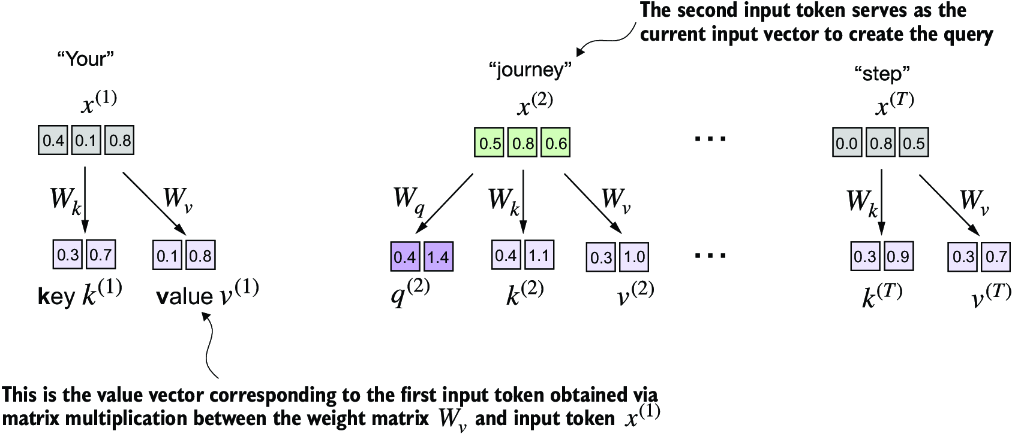

The terms “key,” “query,” and “value” in the context of attention mechanisms are borrowed from the domain of information retrieval and databases, where similar concepts are used to store, search, and retrieve information.

A query is analogous to a search query in a database. It represents the current item (e.g., a word or token in a sentence) the model focuses on or tries to understand. The query is used to probe the other parts of the input sequence to determine how much attention to pay to them.

The key is like a database key used for indexing and searching. In the attention mechanism, each item in the input sequence (e.g., each word in a sentence) has an associated key. These keys are used to match the query.

The value in this context is similar to the value in a key-value pair in a database. It represents the actual content or representation of the input items. Once the model determines which keys (and thus which parts of the input) are most relevant to the query (the current focus item), it retrieves the corresponding values.

Weight params vs attention weights

In the weight matrices W, the term “weight” is short for “weight parameters,” the values of a neural network that are optimized during training. This is not to be confused with the attention weights. As we already saw, attention weights determine the extent to which a context vector depends on the different parts of the input (i.e., to what extent the network focuses on different parts of the input).

In summary, weight parameters are the fundamental, learned coefficients that define the network’s connections, while attention weights are dynamic, context-specific

We compute the attention weights by scaling the attention scores and using the softmax function. However, now we scale the attention scores by dividing them by the square root of the embedding dimension of the keys (taking the square root is mathematically the same as exponentiating by 0.5):

The reason for the normalization by the embedding dimension size is to improve the training performance by avoiding small gradients. For instance, when scaling up the embedding dimension, which is typically greater than 1,000 for GPT-like LLMs, large dot products can result in very small gradients during backpropagation due to the softmax function applied to them. As dot products increase, the softmax function behaves more like a step function, resulting in gradients nearing zero. These small gradients can drastically slow down learning or cause training to stagnate.

The scaling by the square root of the embedding dimension is the reason why this self-attention mechanism is also called scaled-dot product attention. values.apter-1)

In [2]:


import torch.nn as nn
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        # initialize the weights matrices
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key # 
        queries = x @ self.W_query # 
        values = x @ self.W_value
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

This `forward` method implements **scaled dot-product self-attention**: it turns input token embeddings into queries/keys/values, computes attention weights, and uses them to produce **context vectors** (enriched token representations) .

Step by step:

1. **Project inputs into keys, queries, values**
   ```python
   keys    = x @ self.W_key
   queries = x @ self.W_query
   values  = x @ self.W_value
   ```
   Here `x` is a matrix of token embeddings (one row per token). Multiplying by the trainable matrices `W_key`, `W_query`, `W_value` produces the **K**, **Q**, **V** representations used by attention .

2. **Compute attention scores (similarity between each query and each key)**
   ```python
   attn_scores = queries @ keys.T  # omega
   ```
   This creates a score matrix ω where each entry is a dot product between a token’s query and another token’s key .

3. **Convert scores to attention weights (normalize with scaling + softmax)**
   ```python
   attn_weights = torch.softmax(
       attn_scores / keys.shape[-1]**0.5, dim=-1
   )
   ```
   - Dividing by `sqrt(d_k)` (where `d_k = keys.shape[-1]`) is the “scaled” part of **scaled dot-product attention**, used to improve training behavior .
   - `softmax(..., dim=-1)` normalizes each row so the weights across all tokens sum to 1 (per query token) .

4. **Compute context vectors as weighted sums of values**
   ```python
   context_vec = attn_weights @ values
   return context_vec
   ```
   This produces one **context vector per input token** by combining (summing) the value vectors weighted by the attention weights .

Net effect: given token embeddings `x`, it returns context vectors `Z` that incorporate information from other tokens in the sequence via attention .

[1] [Build a Large Language Model (From Scratch) (chapter-3) by Sebastian Raschka](https://livebook.manning.com/book/raschka/chapter-3)